# Задача 6. Компьютерное зрение: задача сегментации

**Автор**: Степырев Даниил Федорович

**Группа**: 22.М05

## Задание

Выполненные пункты:
- [✔️] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику jaccard index. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для jaccard index, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.

- [✔️] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.

- [✔️] Попробовать улучшить качество изменяя архитектуру.

## Датасет

В задаче используется датасет, указанный в условии. Доступен по ссылке: https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view. В датасете есть набор изображений людей и набор масок.

## Подключение библиотек

Подключим используемые библиотеки:

In [1]:
import random

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Зафиксируем сиды для воспроизведения результатов:

In [2]:
def set_seeds(initializer = 47):
    random.seed(initializer)
    torch.manual_seed(initializer)
    
set_seeds()

# Подготовка данных


Подключим Google Drive к Google Colab:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Распакуем архив с датасетом, который находится в корне Google Drive:

In [4]:
!unzip gdrive/My\ Drive/dataset.zip &> /dev/null

## Train/Test split

Считаем список путей изображений в папке **dataset/images/**:

In [5]:
from glob import glob

IMAGES_FOLDER_PATH = "./dataset/images"

imgs_list = glob(f"{IMAGES_FOLDER_PATH}/*")
print(f"Images list length: {len(imgs_list)}")

Images list length: 2000


Заведём класс для хранения изображений и их масок.

Название изображения маски похоже на название исходного изображения. Достаточно заменить папку с **images** на **masks**, а также сменить расширение файла с **.jpg** на **.png**. Тогда для получения изображения и его маски необходимо знать лишь путь до изображения.

In [6]:
from torch.utils.data import Dataset
import numpy as np
import torch
import torchvision
from torchvision import io
import cv2

class SelfieDataset(Dataset):
    def __init__(self, imgs_list, transform = lambda id: id):
        self.imgs = imgs_list
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def get_mask_path(self, img_path):
        mask_path = img_path.split("/")
        mask_path[-2] = mask_path[-2].replace("images", "masks")
        mask_path[-1] = mask_path[-1][:-4] + ".png"
        mask_path = "/".join(mask_path)
        return mask_path

    def resize_image(self, img):
        return torchvision.transforms.Resize((256, 256))(img)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = self.resize_image(io.read_image(img_path))
        img = self.transform(img / 255)
        
        mask_path = self.get_mask_path(img_path)
        mask = self.resize_image(io.read_image(mask_path))
        mask = self.transform(mask / 255)

        return img, mask

Заведём test и train выборки:

In [7]:
train_dataset = SelfieDataset(imgs_list[:-300])
test_dataset = SelfieDataset(imgs_list[-300:])

print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 1700
Test dataset length: 300


Заведём функцию для отображения изображения из SelfieDataset:

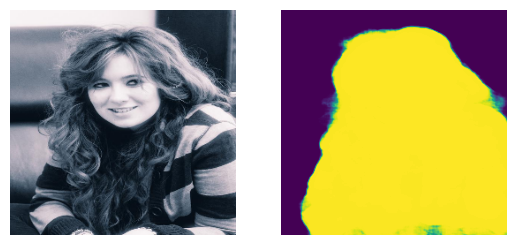

In [26]:
from torchvision.transforms import functional

def show_selfie(image, mask, is_mask_shown=True):
    _, (ax_l, ax_r) = plt.subplots(ncols=2)
    ax_l.imshow(functional.to_pil_image(image))
    ax_l.axis("off")
    ax_r.imshow(functional.to_pil_image(mask))
    ax_r.axis("off")

image, mask = train_dataset[0]
show_selfie(image, mask)

## Jaccard Index метрика

Добавим функцию вычисления Jaccard Index метрики из библиотеки torchmetrics:

In [9]:
!pip install torchmetrics  &> /dev/null
import torchmetrics

jaccard = torchmetrics.JaccardIndex(task="binary")

def calculate_jaccard_metric(y_pred, y_true):
    return jaccard(y_pred.cpu(), y_true.cpu() > jaccard.threshold)

## Реализация UNET

Реализуем UNET аналогично тому, как делали на практическом занятии.

Реализация Encoder:

In [10]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections
    
    

Реализация Decoder:

In [11]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

Реализация UNET:

In [12]:
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

## Переобучение на одном батче

Выполним переобучение на одном батче. Возьмём четыре картинки.

In [13]:
train_subset = torch.utils.data.Subset(train_dataset, range(4))
train_dataset_loader = torch.utils.data.DataLoader(train_subset, batch_size=4)

test_subset = torch.utils.data.Subset(test_dataset, range(4))
test_dataset_loader = torch.utils.data.DataLoader(test_subset, batch_size=4)

Реализуем функции обучения модели. Вычисленные значения loss, Jaccard Index Metric будем сохранять в словарь, чтобы по итогу обучения вернуть датафрейм. Датафрейм будет полезен для построения графиков.

In [14]:
from tqdm import tqdm

TRAIN_DATASET_NAME = "Train dataset"
TEST_DATASET_NAME = "Test dataset"
LOSS_PARAMETER = "Loss"
JACCARD_INDEX_PARAMETER = "Jaccard Index"
device = "cuda"

results_columns = ["Epoch number", "Dataset", "Parameter", "Result"]

net = UNET(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

def train(net, optimizer, loader):
    net.train()

    running_loss = 0.0
    running_metric = 0.0
    for x, y in tqdm(loader):
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()
        pred = net(x)
        
        loss = criterion(pred, y)
        metric = calculate_jaccard_metric(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_metric += metric.item()

    return running_loss / len(loader), running_metric / len(loader)


def predict(net, loader):
    net.eval()

    running_loss = 0.0
    running_metric = 0.0
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.cuda()
            y = y.cuda()
            pred = net(x)
            running_loss += criterion(pred, y).item()
            running_metric += calculate_jaccard_metric(pred, y).item()

    return running_loss / len(loader), running_metric / len(loader)


def train_model(net, optimizer, train_dataset_loader, test_dataset_loader, epoch_number):
    results = []
    for epoch in range(epoch_number):
        loss_train, metric_train = train(net, optimizer, train_dataset_loader)
        loss_test, metric_test = predict(net, test_dataset_loader)
        results += [
            (epoch, TRAIN_DATASET_NAME, LOSS_PARAMETER, loss_train),
            (epoch, TRAIN_DATASET_NAME, JACCARD_INDEX_PARAMETER, metric_train),
            (epoch, TEST_DATASET_NAME, LOSS_PARAMETER, loss_test),
            (epoch, TEST_DATASET_NAME, JACCARD_INDEX_PARAMETER, metric_test),
        ]

    return pd.DataFrame(results, columns=results_columns)

Выполним переобучение на одном батче:

In [15]:
train_model(net, optimizer, train_dataset_loader, test_dataset_loader, 50).to_csv("results-batch.csv")

100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Заведём функцию отображения результатов:

In [16]:
def show_result_plot(results, plot_title = ""):
    fig, (ax_1, ax_2) = plt.subplots(nrows=2, sharex=True, figsize=(15, 5))

    sns.lineplot(results[results["Parameter"] == LOSS_PARAMETER], x="Epoch number", y="Result", hue="Dataset",ax=ax_1)
    ax_1.set_title(LOSS_PARAMETER)

    sns.lineplot(results[results["Parameter"] == JACCARD_INDEX_PARAMETER], x="Epoch number", y="Result", hue="Dataset", ax=ax_2)
    ax_2.set_title(JACCARD_INDEX_PARAMETER)

    fig.suptitle(plot_title)
    fig.tight_layout()

Построим график обучения на одном батче:

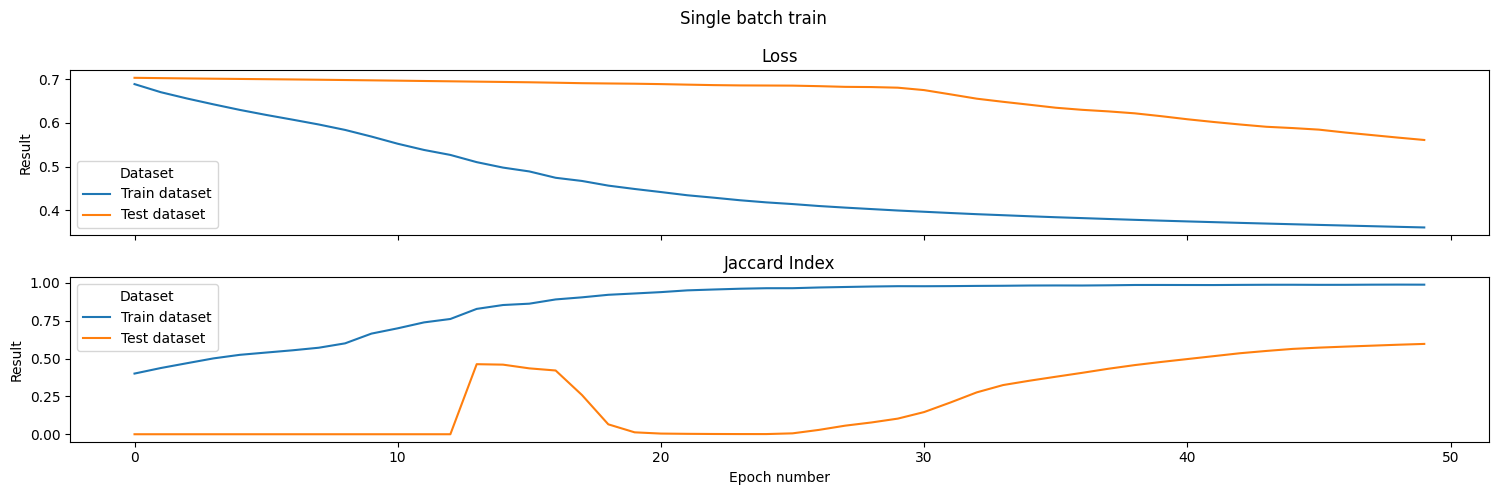

In [17]:
results = pd.read_csv("results-batch.csv")
show_result_plot(results, "Single batch train")

In [18]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0             0             0  Train dataset           Loss  0.689161
1             1             0  Train dataset  Jaccard Index  0.401114
2             2             0   Test dataset           Loss  0.703619
3             3             0   Test dataset  Jaccard Index  0.000000
4             4             1  Train dataset           Loss  0.670593
..          ...           ...            ...            ...       ...
195         195            48   Test dataset  Jaccard Index  0.591777
196         196            49  Train dataset           Loss  0.360272
197         197            49  Train dataset  Jaccard Index  0.988883
198         198            49   Test dataset           Loss  0.560965
199         199            49   Test dataset  Jaccard Index  0.597223

[200 rows x 5 columns]

Train dataset result
Test dataset result


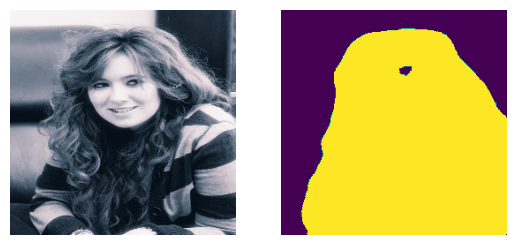

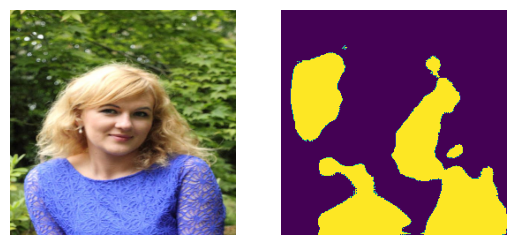

In [29]:
net.eval()

print("Train dataset result")
train_img, mask = train_dataset[0]
train_mask = net(train_img.cuda().unsqueeze(0))[0].cpu()
show_selfie(train_img, nn.functional.sigmoid(train_mask > 0))

print("Test dataset result")
test_img, mask = test_dataset[0]
test_mask = net(test_img.cuda().unsqueeze(0))[0].cpu()
show_selfie(test_img, nn.functional.sigmoid(test_mask > 0))

Видим, что результат обучающей выборки лучше результата тестовой. При возрастании числа шагов обучения снижается Loss и возрастает Jaccard Index.

# Обучение на всём Train

Выполним обучение на всей Train выборке. В качестве размера батча возьмём число 16.

In [ ]:
batch_size = 16
epoch_number = 15 # Google Colab limits accounts for a big computations
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Обучим модель на всей выборке. Возьмём для теста 15 эпох. Результаты сохраним в results.csv.

In [ ]:
from torch.utils.data.datapipes.datapipe import UNTRACABLE_DATAFRAME_PIPES
net = UNET(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv("results.csv")

100%|██████████| 19/19 [00:04<00:00,  3.92it/s]


Построим график результатов обучения модели на всей выборке:

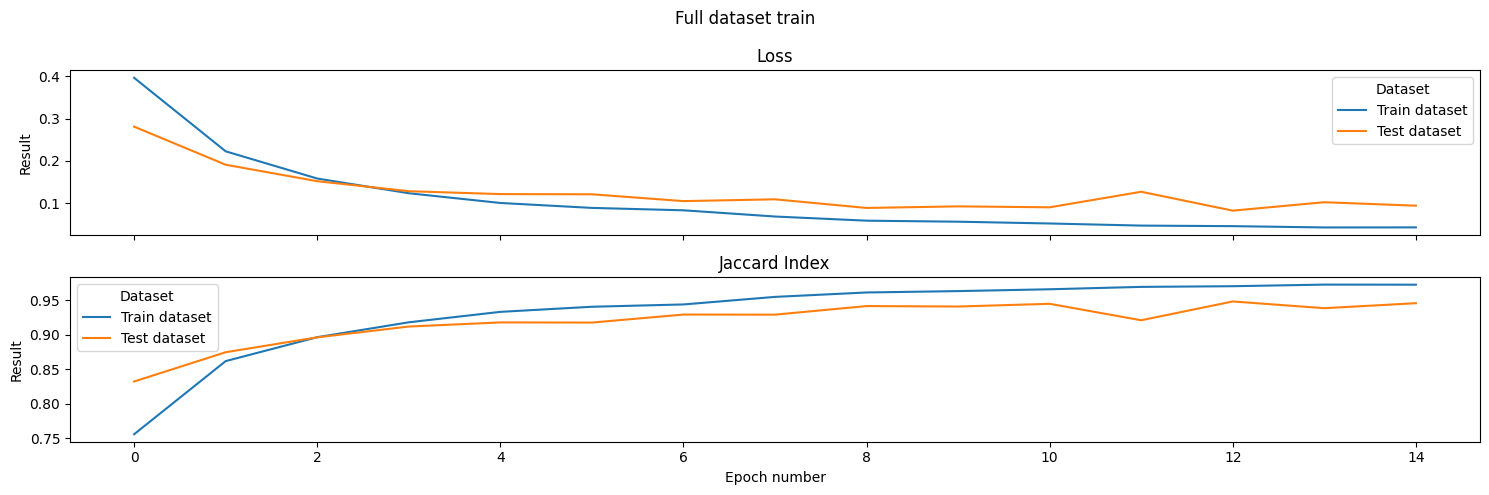

In [ ]:
results = pd.read_csv("results.csv")
show_result_plot(results, "Full dataset train")

Из графика видим, что с увеличением числа шагов уменьшается Loss и увеличчивается Jaccard Index.

Выведем полученные результаты как таблицу:

In [ ]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.396746
1            1             0  Train dataset  Jaccard Index  0.755891
2            2             0   Test dataset           Loss  0.281245
3            3             0   Test dataset  Jaccard Index  0.832161
4            4             1  Train dataset           Loss  0.222811
5            5             1  Train dataset  Jaccard Index  0.861666
6            6             1   Test dataset           Loss  0.191095
7            7             1   Test dataset  Jaccard Index  0.874498
8            8             2  Train dataset           Loss  0.158458
9            9             2  Train dataset  Jaccard Index  0.896273
10          10             2   Test dataset           Loss  0.152167
11          11             2   Test dataset  Jaccard Index  0.896059
12          12             3  Train dataset           Loss  0.123671
13          13             3  Train dataset  Jaccard Index  0.917798
14          14             3   Test dataset           Loss  0.128467
15          15             3   Test dataset  Jaccard Index  0.911663
16          16             4  Train dataset           Loss  0.100644
17          17             4  Train dataset  Jaccard Index  0.932900
18          18             4   Test dataset           Loss  0.121654
19          19             4   Test dataset  Jaccard Index  0.917640
20          20             5  Train dataset           Loss  0.088965
21          21             5  Train dataset  Jaccard Index  0.940286
22          22             5   Test dataset           Loss  0.121170
23          23             5   Test dataset  Jaccard Index  0.917413
24          24             6  Train dataset           Loss  0.083297
25          25             6  Train dataset  Jaccard Index  0.943626
26          26             6   Test dataset           Loss  0.105042
27          27             6   Test dataset  Jaccard Index  0.929000
28          28             7  Train dataset           Loss  0.068576
29          29             7  Train dataset  Jaccard Index  0.954553
30          30             7   Test dataset           Loss  0.109282
31          31             7   Test dataset  Jaccard Index  0.928867
32          32             8  Train dataset           Loss  0.058764
33          33             8  Train dataset  Jaccard Index  0.960942
34          34             8   Test dataset           Loss  0.088872
35          35             8   Test dataset  Jaccard Index  0.941273
36          36             9  Train dataset           Loss  0.056323
37          37             9  Train dataset  Jaccard Index  0.962927
38          38             9   Test dataset           Loss  0.092593
39          39             9   Test dataset  Jaccard Index  0.940622
40          40            10  Train dataset           Loss  0.052101
41          41            10  Train dataset  Jaccard Index  0.965576
42          42            10   Test dataset           Loss  0.090375
43          43            10   Test dataset  Jaccard Index  0.944552
44          44            11  Train dataset           Loss  0.047106
45          45            11  Train dataset  Jaccard Index  0.969029
46          46            11   Test dataset           Loss  0.127172
47          47            11   Test dataset  Jaccard Index  0.920749
48          48            12  Train dataset           Loss  0.045797
49          49            12  Train dataset  Jaccard Index  0.970003
50          50            12   Test dataset           Loss  0.082472
51          51            12   Test dataset  Jaccard Index  0.947948
52          52            13  Train dataset           Loss  0.042727
53          53            13  Train dataset  Jaccard Index  0.972321
54          54            13   Test dataset           Loss  0.102405
55          55            13   Test dataset  Jaccard Index  0.938212
56          56            14  Train dataset           Loss  0.042880
57

Реализуем функцию отбора самых плохих предсказаний:

In [ ]:
def show_worst_predictions(net, number):
    predictions = []
    for i, data in tqdm(enumerate(test_loader, 0)):
        x = data[0]
        y = data[1]
        pred = net(x.cuda())
        metric = calculate_jaccard_metric(pred, y).item()
        predictions.append((metric, i))

    worst_predictions = sorted(predictions)[:number]
    for _, idx in worst_predictions:
        image, mask = test_dataset[idx]
        pred = net(image.cuda().unsqueeze(0))
        show_selfie(image, pred[0].cpu())

Найдем 5 худших результатов:

19it [00:04,  3.86it/s]


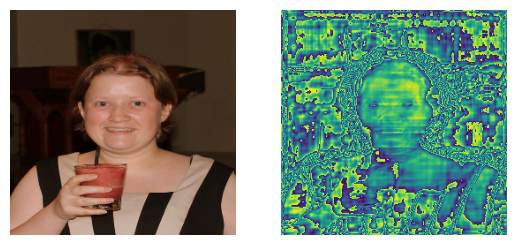

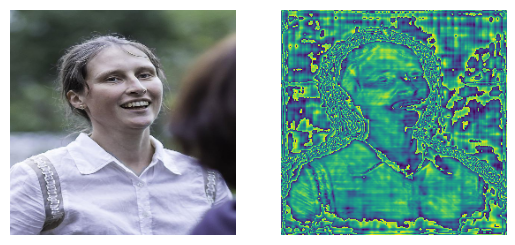

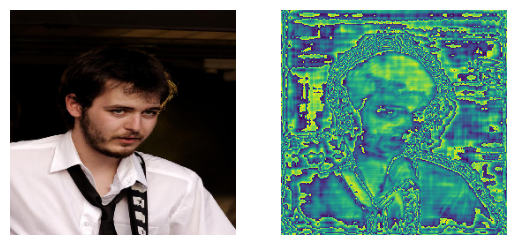

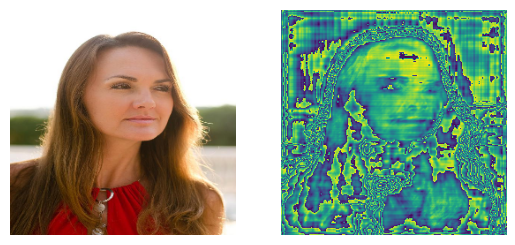

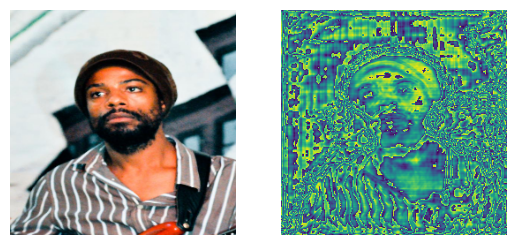

In [ ]:
show_worst_predictions(net, 5)

Видим, что хоть результаты и не очень, удалось выделить контур лица человека.

# Аугментация

Попробуем улучшить качество предсказаний с помощью аугментации. Модифицируем существующие данные для увеличения выборки.

Применим отражение по горизонтали (horizontal flip) и изменение цвета изображения (color jitter):

In [ ]:
import copy
from torchvision import transforms

transformations = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=.5, hue=.3)
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = transformations

train_dataset_extended = torch.utils.data.ConcatDataset(
    [train_dataset_augmented, copy.copy(train_dataset)]
)

train_loader_extended = torch.utils.data.DataLoader(train_dataset_extended, batch_size=batch_size)

(-0.5, 255.5, 255.5, -0.5)

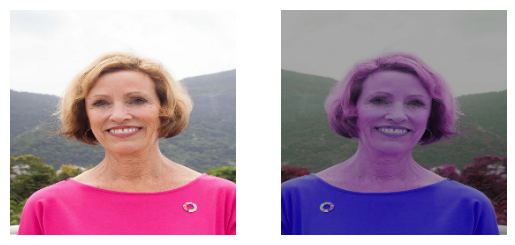

In [ ]:
img_train, mask = train_dataset[0]
img_aug, mask = train_dataset_augmented[0]

_, (ax_l, ax_r) = plt.subplots(ncols=2)
ax_l.imshow(functional.to_pil_image(img_train))
ax_l.axis("off")
ax_r.imshow(functional.to_pil_image(img_aug))
ax_r.axis("off")

Дообучим прошлую модель на расширенных данных:

In [ ]:
train_model(net, optimizer, train_loader_extended, test_loader, epoch_number).to_csv("results-augmented.csv")

100%|██████████| 19/19 [00:04<00:00,  4.44it/s]


Сразу можно заметить, что время обучения возросло в три раза. Построим график с результатами:

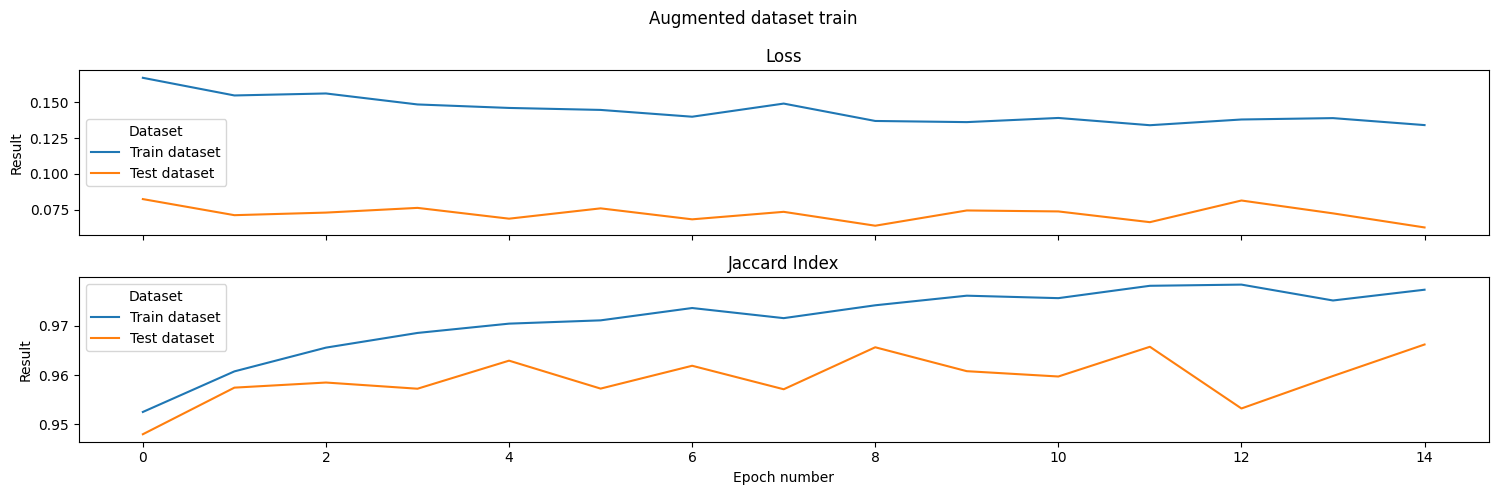

In [ ]:
results = pd.read_csv("results-augmented.csv")
show_result_plot(results, "Augmented dataset train")

Видим на графике, что Loss для тестовой выборки уменьшился, а Jaccard Index увеличился.

Выведем таблицу значений:

In [ ]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.167071
1            1             0  Train dataset  Jaccard Index  0.952497
2            2             0   Test dataset           Loss  0.082310
3            3             0   Test dataset  Jaccard Index  0.947964
4            4             1  Train dataset           Loss  0.154740
5            5             1  Train dataset  Jaccard Index  0.960754
6            6             1   Test dataset           Loss  0.071071
7            7             1   Test dataset  Jaccard Index  0.957446
8            8             2  Train dataset           Loss  0.156133
9            9             2  Train dataset  Jaccard Index  0.965586
10          10             2   Test dataset           Loss  0.072876
11          11             2   Test dataset  Jaccard Index  0.958483
12          12             3  Train dataset           Loss  0.148456
13          13             3  Train dataset  Jaccard Index  0.968574
14          14             3   Test dataset           Loss  0.076167
15          15             3   Test dataset  Jaccard Index  0.957226
16          16             4  Train dataset           Loss  0.146018
17          17             4  Train dataset  Jaccard Index  0.970466
18          18             4   Test dataset           Loss  0.068626
19          19             4   Test dataset  Jaccard Index  0.962935
20          20             5  Train dataset           Loss  0.144634
21          21             5  Train dataset  Jaccard Index  0.971135
22          22             5   Test dataset           Loss  0.075836
23          23             5   Test dataset  Jaccard Index  0.957249
24          24             6  Train dataset           Loss  0.139886
25          25             6  Train dataset  Jaccard Index  0.973644
26          26             6   Test dataset           Loss  0.068168
27          27             6   Test dataset  Jaccard Index  0.961896
28          28             7  Train dataset           Loss  0.149062
29          29             7  Train dataset  Jaccard Index  0.971585
30          30             7   Test dataset           Loss  0.073410
31          31             7   Test dataset  Jaccard Index  0.957116
32          32             8  Train dataset           Loss  0.136914
33          33             8  Train dataset  Jaccard Index  0.974200
34          34             8   Test dataset           Loss  0.063705
35          35             8   Test dataset  Jaccard Index  0.965658
36          36             9  Train dataset           Loss  0.136112
37          37             9  Train dataset  Jaccard Index  0.976153
38          38             9   Test dataset           Loss  0.074364
39          39             9   Test dataset  Jaccard Index  0.960793
40          40            10  Train dataset           Loss  0.139016
41          41            10  Train dataset  Jaccard Index  0.975653
42          42            10   Test dataset           Loss  0.073691
43          43            10   Test dataset  Jaccard Index  0.959712
44          44            11  Train dataset           Loss  0.133942
45          45            11  Train dataset  Jaccard Index  0.978166
46          46            11   Test dataset           Loss  0.066183
47          47            11   Test dataset  Jaccard Index  0.965759
48          48            12  Train dataset           Loss  0.137942
49          49            12  Train dataset  Jaccard Index  0.978408
50          50            12   Test dataset           Loss  0.081325
51          51            12   Test dataset  Jaccard Index  0.953207
52          52            13  Train dataset           Loss  0.138905
53          53            13  Train dataset  Jaccard Index  0.975177
54          54            13   Test dataset           Loss  0.072337
55          55            13   Test dataset  Jaccard Index  0.959813
56          56            14  Train dataset           Loss  0.134030
57

Посмотрим на 5 худших предсказаний:

19it [00:04,  4.29it/s]


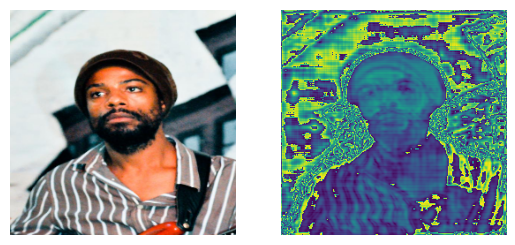

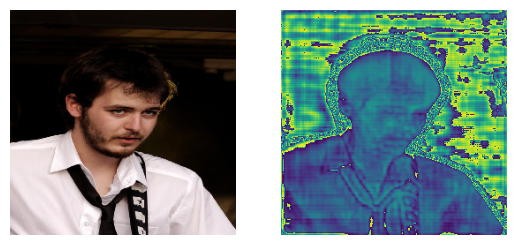

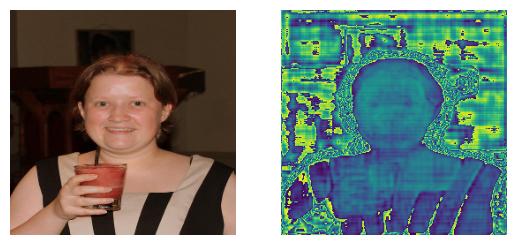

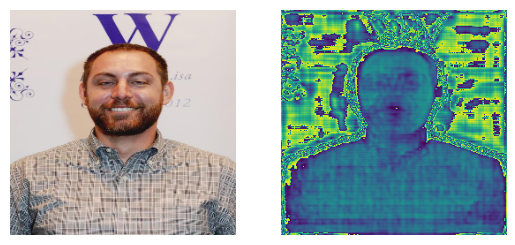

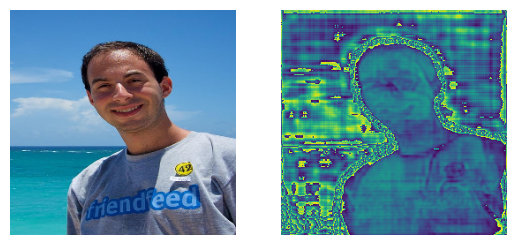

In [ ]:
show_worst_predictions(net, 5)

Также можно заметить, что на худших предсказаниях при аугментированном датасете можно хорошо раглядеть контур человека. Результат визуально лучше, чем до аугментации.

# Гиперпараметры

Попробуем улучшить качество предсказаний с помощью подбора гиперпараметров. Попробуем разные значения n_down:

In [ ]:
def train_and_save_to_csv(n_down, train_loader, test_loader):
    net = UNET(3, 16, 1, n_down=n_down).cuda()
    optimizer = torch.optim.Adam(net.parameters())

    train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv(f"results-hyperparam-{n_down}.csv")

n_down_parameters = [2, 4, 8]
for n_down in n_down_parameters:
    print(f"Training net with {n_down} n_down")
    train_and_save_to_csv(n_down, train_loader, test_loader)

Training net with 2 n_down


100%|██████████| 19/19 [00:04<00:00,  4.61it/s]


Training net with 4 n_down


100%|██████████| 19/19 [00:05<00:00,  3.75it/s]


Training net with 8 n_down


100%|██████████| 19/19 [00:05<00:00,  3.29it/s]


Посмотрим график результата для n_down = 2:

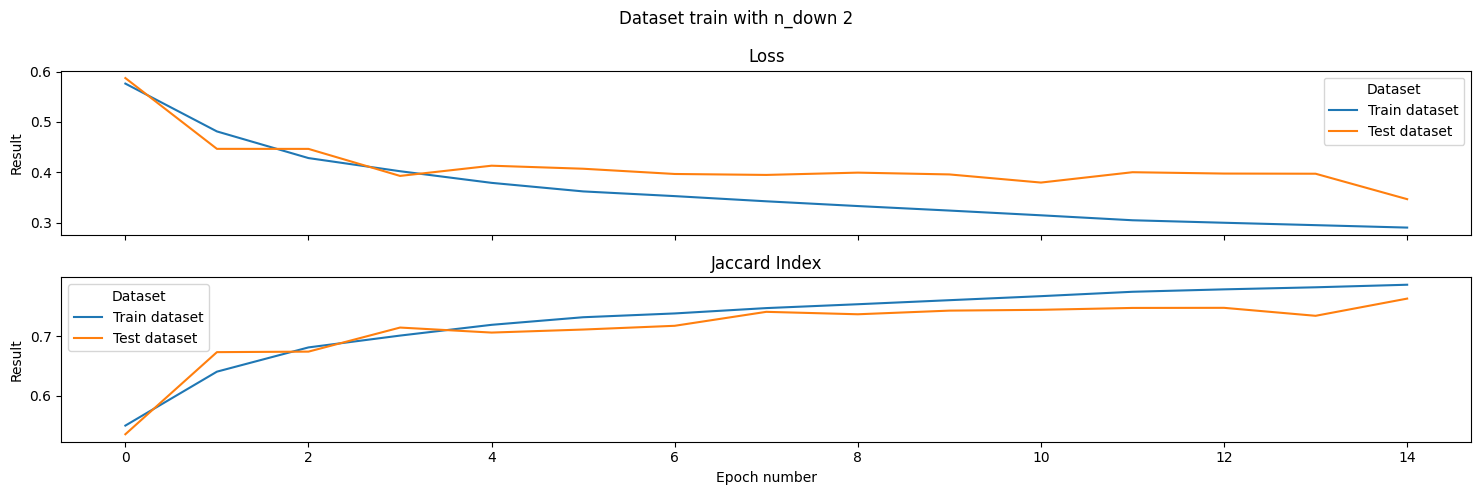

In [ ]:
results = pd.read_csv("results-hyperparam-2.csv")
show_result_plot(results, "Dataset train with n_down 2")

In [ ]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.576233
1            1             0  Train dataset  Jaccard Index  0.549917
2            2             0   Test dataset           Loss  0.587208
3            3             0   Test dataset  Jaccard Index  0.535414
4            4             1  Train dataset           Loss  0.481229
5            5             1  Train dataset  Jaccard Index  0.640279
6            6             1   Test dataset           Loss  0.446598
7            7             1   Test dataset  Jaccard Index  0.672980
8            8             2  Train dataset           Loss  0.428280
9            9             2  Train dataset  Jaccard Index  0.680908
10          10             2   Test dataset           Loss  0.446520
11          11             2   Test dataset  Jaccard Index  0.673849
12          12             3  Train dataset           Loss  0.402162
13          13             3  Train dataset  Jaccard Index  0.700718
14          14             3   Test dataset           Loss  0.392830
15          15             3   Test dataset  Jaccard Index  0.714167
16          16             4  Train dataset           Loss  0.379037
17          17             4  Train dataset  Jaccard Index  0.718748
18          18             4   Test dataset           Loss  0.413137
19          19             4   Test dataset  Jaccard Index  0.705775
20          20             5  Train dataset           Loss  0.362062
21          21             5  Train dataset  Jaccard Index  0.731463
22          22             5   Test dataset           Loss  0.407109
23          23             5   Test dataset  Jaccard Index  0.710847
24          24             6  Train dataset           Loss  0.352706
25          25             6  Train dataset  Jaccard Index  0.737828
26          26             6   Test dataset           Loss  0.396683
27          27             6   Test dataset  Jaccard Index  0.717124
28          28             7  Train dataset           Loss  0.342417
29          29             7  Train dataset  Jaccard Index  0.746778
30          30             7   Test dataset           Loss  0.394805
31          31             7   Test dataset  Jaccard Index  0.740517
32          32             8  Train dataset           Loss  0.332964
33          33             8  Train dataset  Jaccard Index  0.753248
34          34             8   Test dataset           Loss  0.399358
35          35             8   Test dataset  Jaccard Index  0.736438
36          36             9  Train dataset           Loss  0.324008
37          37             9  Train dataset  Jaccard Index  0.760025
38          38             9   Test dataset           Loss  0.395792
39          39             9   Test dataset  Jaccard Index  0.742545
40          40            10  Train dataset           Loss  0.314598
41          41            10  Train dataset  Jaccard Index  0.766774
42          42            10   Test dataset           Loss  0.379634
43          43            10   Test dataset  Jaccard Index  0.743914
44          44            11  Train dataset           Loss  0.304742
45          45            11  Train dataset  Jaccard Index  0.774129
46          46            11   Test dataset           Loss  0.400183
47          47            11   Test dataset  Jaccard Index  0.747055
48          48            12  Train dataset           Loss  0.299792
49          49            12  Train dataset  Jaccard Index  0.778177
50          50            12   Test dataset           Loss  0.397516
51          51            12   Test dataset  Jaccard Index  0.747227
52          52            13  Train dataset           Loss  0.295021
53          53            13  Train dataset  Jaccard Index  0.781640
54          54            13   Test dataset           Loss  0.397184
55          55            13   Test dataset  Jaccard Index  0.733863
56          56            14  Train dataset           Loss  0.290185
57

Посмотрим график результата для n_down = 4:

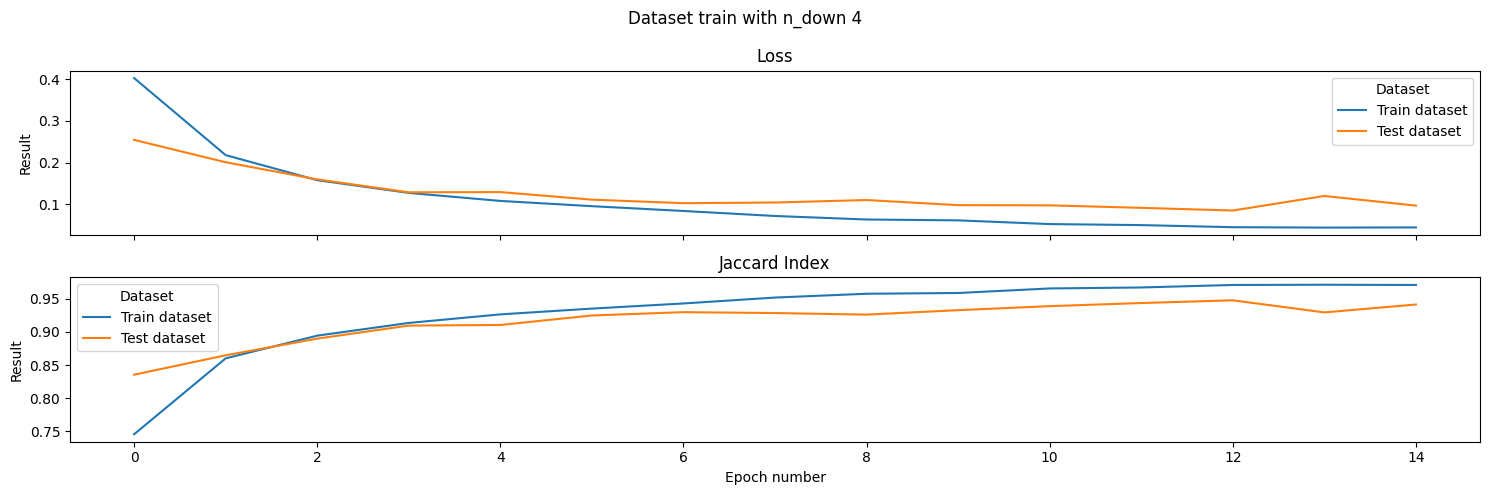

In [ ]:
results = pd.read_csv("results-hyperparam-4.csv")
show_result_plot(results, "Dataset train with n_down 4")

In [ ]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.402436
1            1             0  Train dataset  Jaccard Index  0.745621
2            2             0   Test dataset           Loss  0.254374
3            3             0   Test dataset  Jaccard Index  0.835432
4            4             1  Train dataset           Loss  0.217921
5            5             1  Train dataset  Jaccard Index  0.860063
6            6             1   Test dataset           Loss  0.200869
7            7             1   Test dataset  Jaccard Index  0.864691
8            8             2  Train dataset           Loss  0.157922
9            9             2  Train dataset  Jaccard Index  0.894293
10          10             2   Test dataset           Loss  0.159807
11          11             2   Test dataset  Jaccard Index  0.889810
12          12             3  Train dataset           Loss  0.127457
13          13             3  Train dataset  Jaccard Index  0.913486
14          14             3   Test dataset           Loss  0.128866
15          15             3   Test dataset  Jaccard Index  0.909491
16          16             4  Train dataset           Loss  0.108253
17          17             4  Train dataset  Jaccard Index  0.926379
18          18             4   Test dataset           Loss  0.129421
19          19             4   Test dataset  Jaccard Index  0.910407
20          20             5  Train dataset           Loss  0.095678
21          21             5  Train dataset  Jaccard Index  0.935098
22          22             5   Test dataset           Loss  0.111308
23          23             5   Test dataset  Jaccard Index  0.924732
24          24             6  Train dataset           Loss  0.084184
25          25             6  Train dataset  Jaccard Index  0.942852
26          26             6   Test dataset           Loss  0.102813
27          27             6   Test dataset  Jaccard Index  0.929737
28          28             7  Train dataset           Loss  0.072180
29          29             7  Train dataset  Jaccard Index  0.951752
30          30             7   Test dataset           Loss  0.104426
31          31             7   Test dataset  Jaccard Index  0.928405
32          32             8  Train dataset           Loss  0.063754
33          33             8  Train dataset  Jaccard Index  0.957490
34          34             8   Test dataset           Loss  0.110370
35          35             8   Test dataset  Jaccard Index  0.926034
36          36             9  Train dataset           Loss  0.061692
37          37             9  Train dataset  Jaccard Index  0.958632
38          38             9   Test dataset           Loss  0.098128
39          39             9   Test dataset  Jaccard Index  0.932736
40          40            10  Train dataset           Loss  0.052812
41          41            10  Train dataset  Jaccard Index  0.965486
42          42            10   Test dataset           Loss  0.097674
43          43            10   Test dataset  Jaccard Index  0.938804
44          44            11  Train dataset           Loss  0.050334
45          45            11  Train dataset  Jaccard Index  0.966966
46          46            11   Test dataset           Loss  0.091689
47          47            11   Test dataset  Jaccard Index  0.943499
48          48            12  Train dataset           Loss  0.045329
49          49            12  Train dataset  Jaccard Index  0.970742
50          50            12   Test dataset           Loss  0.085266
51          51            12   Test dataset  Jaccard Index  0.947607
52          52            13  Train dataset           Loss  0.044397
53          53            13  Train dataset  Jaccard Index  0.971094
54          54            13   Test dataset           Loss  0.120117
55          55            13   Test dataset  Jaccard Index  0.929366
56          56            14  Train dataset           Loss  0.044780
57

Посмотрим график результата для n_down = 8:

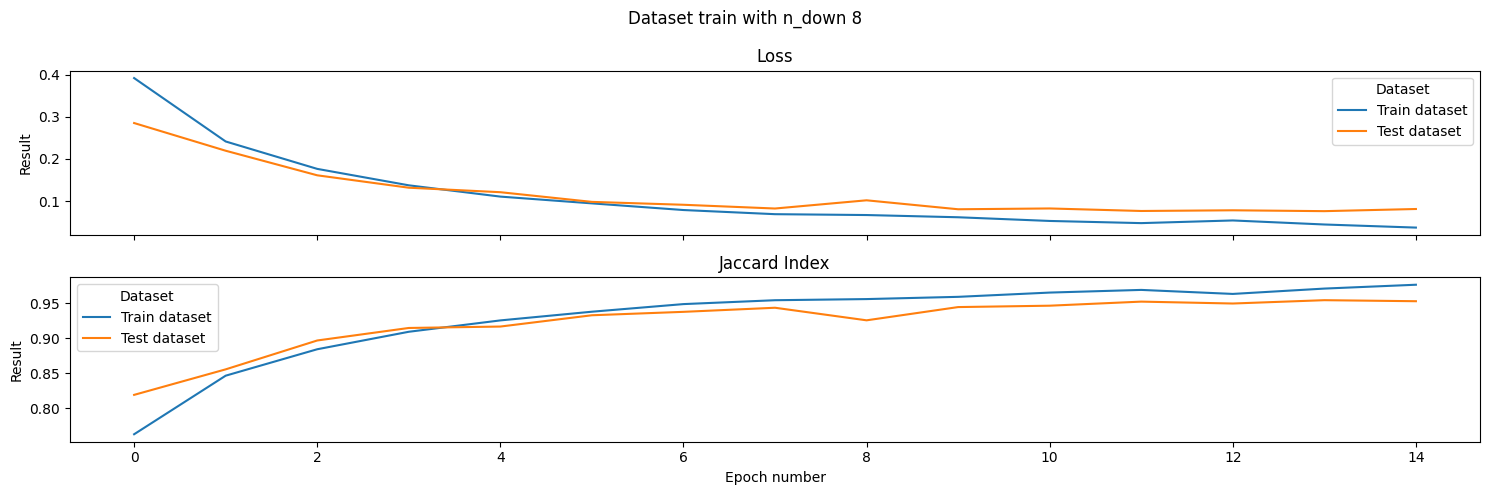

In [ ]:
results = pd.read_csv("results-hyperparam-8.csv")
show_result_plot(results, "Dataset train with n_down 8")

In [ ]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.391900
1            1             0  Train dataset  Jaccard Index  0.763216
2            2             0   Test dataset           Loss  0.285261
3            3             0   Test dataset  Jaccard Index  0.819458
4            4             1  Train dataset           Loss  0.241521
5            5             1  Train dataset  Jaccard Index  0.846870
6            6             1   Test dataset           Loss  0.219566
7            7             1   Test dataset  Jaccard Index  0.855905
8            8             2  Train dataset           Loss  0.176523
9            9             2  Train dataset  Jaccard Index  0.884620
10          10             2   Test dataset           Loss  0.161283
11          11             2   Test dataset  Jaccard Index  0.897134
12          12             3  Train dataset           Loss  0.137538
13          13             3  Train dataset  Jaccard Index  0.909589
14          14             3   Test dataset           Loss  0.131862
15          15             3   Test dataset  Jaccard Index  0.915023
16          16             4  Train dataset           Loss  0.110778
17          17             4  Train dataset  Jaccard Index  0.925820
18          18             4   Test dataset           Loss  0.121198
19          19             4   Test dataset  Jaccard Index  0.917047
20          20             5  Train dataset           Loss  0.094721
21          21             5  Train dataset  Jaccard Index  0.938239
22          22             5   Test dataset           Loss  0.098260
23          23             5   Test dataset  Jaccard Index  0.933168
24          24             6  Train dataset           Loss  0.078916
25          25             6  Train dataset  Jaccard Index  0.949115
26          26             6   Test dataset           Loss  0.091400
27          27             6   Test dataset  Jaccard Index  0.938052
28          28             7  Train dataset           Loss  0.069082
29          29             7  Train dataset  Jaccard Index  0.954653
30          30             7   Test dataset           Loss  0.082516
31          31             7   Test dataset  Jaccard Index  0.943897
32          32             8  Train dataset           Loss  0.067046
33          33             8  Train dataset  Jaccard Index  0.956279
34          34             8   Test dataset           Loss  0.101992
35          35             8   Test dataset  Jaccard Index  0.925943
36          36             9  Train dataset           Loss  0.061781
37          37             9  Train dataset  Jaccard Index  0.959483
38          38             9   Test dataset           Loss  0.080736
39          39             9   Test dataset  Jaccard Index  0.944860
40          40            10  Train dataset           Loss  0.053018
41          41            10  Train dataset  Jaccard Index  0.965572
42          42            10   Test dataset           Loss  0.082647
43          43            10   Test dataset  Jaccard Index  0.946837
44          44            11  Train dataset           Loss  0.047879
45          45            11  Train dataset  Jaccard Index  0.969382
46          46            11   Test dataset           Loss  0.076673
47          47            11   Test dataset  Jaccard Index  0.952653
48          48            12  Train dataset           Loss  0.054197
49          49            12  Train dataset  Jaccard Index  0.963643
50          50            12   Test dataset           Loss  0.078306
51          51            12   Test dataset  Jaccard Index  0.949948
52          52            13  Train dataset           Loss  0.044618
53          53            13  Train dataset  Jaccard Index  0.971280
54          54            13   Test dataset           Loss  0.076263
55          55            13   Test dataset  Jaccard Index  0.954707
56          56            14  Train dataset           Loss  0.037282
57

С увеличением n_down увеличивается время обучения. Модель с параметром n_down оказалось самой быстробучаемой. Самая медленная скорость обучения у модели с n_down = 8.

Если смотреть на значения Loss, то лучше всего отработала модель с параметром n_down = 8.

Если смотреть на значения Jaccard Index, то лучше всего отработала модель с параметром n_down = 8.



Посмотрим на худшие предсказания последней модели:

19it [00:04,  4.29it/s]


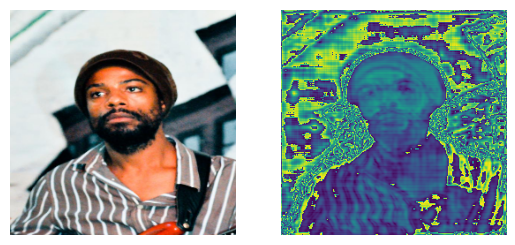

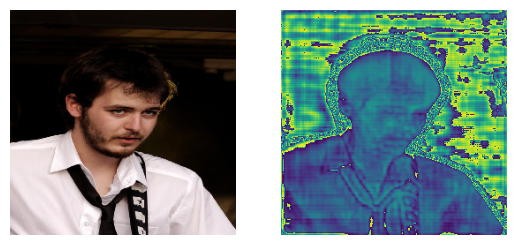

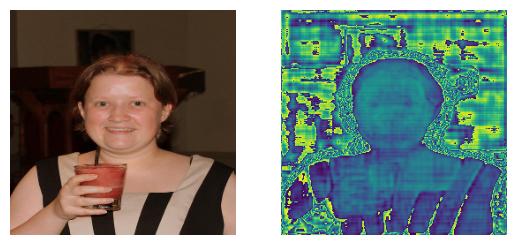

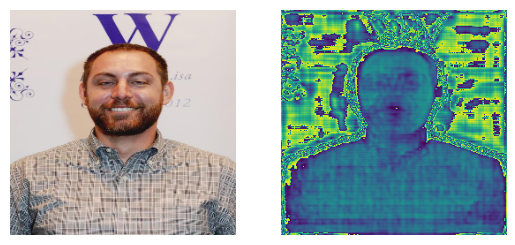

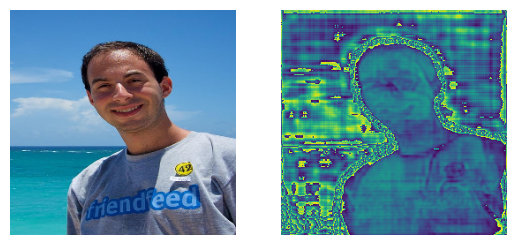

In [ ]:
show_worst_predictions(net, 5)

Видим, что удалось выделить контур фигуры человека.

# Test Time аугментации

Реализуем Test Time аугментацию, используя horizontal flip:

In [ ]:
class SegmentationTTAWrapper(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net


    def horizontal_flip(self, image):
        # Use p = 1 to flip image.
        transformation = transforms.RandomHorizontalFlip(p=1)
        return transformation(image)
    

    def forward(self, image):
        flipped_image = self.horizontal_flip(image)
        concatenated_image = torch.cat([image, flipped_image])
        prediction = self.net(concatenated_image)

        result, augmented_result = prediction.chunk(2)
        flipped_augmented_result = self.horizontal_flip(augmented_result)

        return torch.mean(torch.stack([result, flipped_augmented_result]), dim=0)

Обучим TTA модель:

In [ ]:
net = UNET(3, 8, 1).cuda()
tta_net = SegmentationTTAWrapper(net).cuda()

optimizer = torch.optim.Adam(tta_net.parameters())
train_model(tta_net, optimizer, train_loader, test_loader, epoch_number).to_csv(f"results-tta.csv")

100%|██████████| 19/19 [00:04<00:00,  3.85it/s]


Посмотрим график результата для TTA:

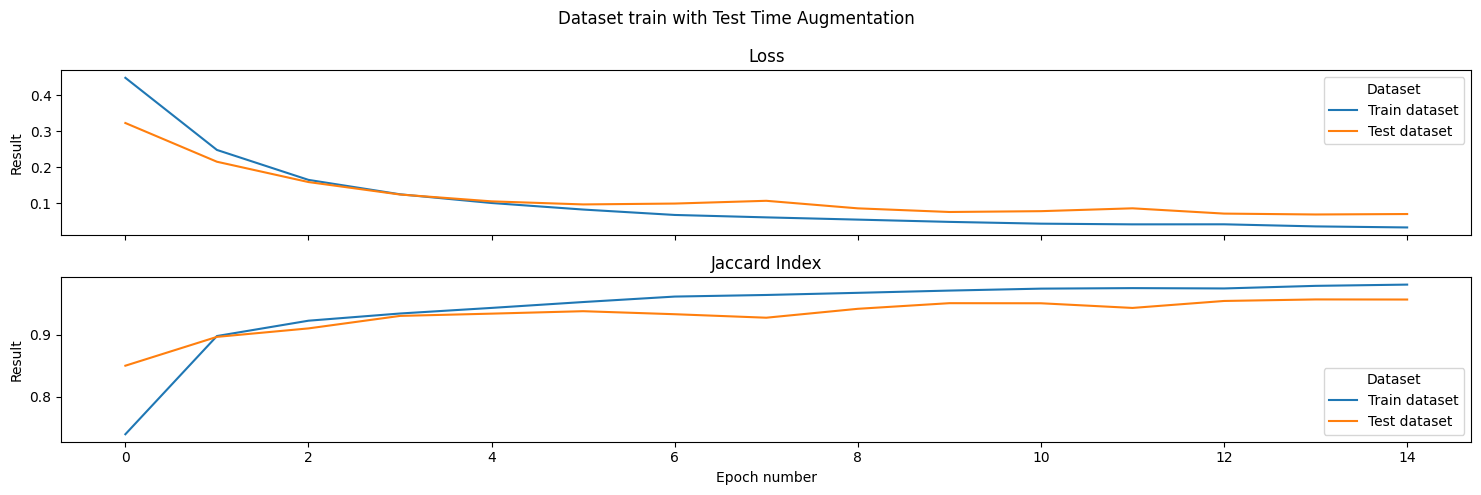

In [ ]:
results = pd.read_csv("results-tta.csv")
show_result_plot(results, "Dataset train with Test Time Augmentation")

In [ ]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.449202
1            1             0  Train dataset  Jaccard Index  0.738982
2            2             0   Test dataset           Loss  0.323269
3            3             0   Test dataset  Jaccard Index  0.849955
4            4             1  Train dataset           Loss  0.248246
5            5             1  Train dataset  Jaccard Index  0.897982
6            6             1   Test dataset           Loss  0.215373
7            7             1   Test dataset  Jaccard Index  0.896625
8            8             2  Train dataset           Loss  0.164813
9            9             2  Train dataset  Jaccard Index  0.922817
10          10             2   Test dataset           Loss  0.158734
11          11             2   Test dataset  Jaccard Index  0.910349
12          12             3  Train dataset           Loss  0.124645
13          13             3  Train dataset  Jaccard Index  0.934470
14          14             3   Test dataset           Loss  0.123995
15          15             3   Test dataset  Jaccard Index  0.930585
16          16             4  Train dataset           Loss  0.100371
17          17             4  Train dataset  Jaccard Index  0.943530
18          18             4   Test dataset           Loss  0.104969
19          19             4   Test dataset  Jaccard Index  0.934246
20          20             5  Train dataset           Loss  0.082154
21          21             5  Train dataset  Jaccard Index  0.953027
22          22             5   Test dataset           Loss  0.096424
23          23             5   Test dataset  Jaccard Index  0.938198
24          24             6  Train dataset           Loss  0.067077
25          25             6  Train dataset  Jaccard Index  0.961888
26          26             6   Test dataset           Loss  0.098828
27          27             6   Test dataset  Jaccard Index  0.933308
28          28             7  Train dataset           Loss  0.060355
29          29             7  Train dataset  Jaccard Index  0.964469
30          30             7   Test dataset           Loss  0.106527
31          31             7   Test dataset  Jaccard Index  0.927656
32          32             8  Train dataset           Loss  0.054095
33          33             8  Train dataset  Jaccard Index  0.967946
34          34             8   Test dataset           Loss  0.085491
35          35             8   Test dataset  Jaccard Index  0.942070
36          36             9  Train dataset           Loss  0.047782
37          37             9  Train dataset  Jaccard Index  0.971575
38          38             9   Test dataset           Loss  0.075348
39          39             9   Test dataset  Jaccard Index  0.951187
40          40            10  Train dataset           Loss  0.042806
41          41            10  Train dataset  Jaccard Index  0.974728
42          42            10   Test dataset           Loss  0.077629
43          43            10   Test dataset  Jaccard Index  0.951032
44          44            11  Train dataset           Loss  0.040887
45          45            11  Train dataset  Jaccard Index  0.975567
46          46            11   Test dataset           Loss  0.085572
47          47            11   Test dataset  Jaccard Index  0.943487
48          48            12  Train dataset           Loss  0.041025
49          49            12  Train dataset  Jaccard Index  0.975021
50          50            12   Test dataset           Loss  0.070858
51          51            12   Test dataset  Jaccard Index  0.954770
52          52            13  Train dataset           Loss  0.035194
53          53            13  Train dataset  Jaccard Index  0.979231
54          54            13   Test dataset           Loss  0.068403
55          55            13   Test dataset  Jaccard Index  0.957252
56          56            14  Train dataset           Loss  0.032267
57

Из графика и результатов видим, что по сравнению с обычной UNET моделью значение Loss стало меньше, а Jaccard Index больше.

Было:
- Loss = 0.094;
- Jaccard Index = 0.945.

Стало:
- Loss = 0.069;
- Jaccard Index = 0.957.

# Изменение архитектуры

Попробуем улучшить качество, изменив архитектуру решения. Возьмём архитектуру, описанную из Pytorch-UNet: https://github.com/milesial/Pytorch-UNet.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

  
class UNetNew(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNetNew, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [ ]:
net = UNetNew(3, 1).cuda()
optimizer = torch.optim.Adam(net.parameters())

train_model(net, optimizer, train_loader, test_loader, epoch_number + 5).to_csv("results-architecture.csv")

100%|██████████| 19/19 [00:08<00:00,  2.32it/s]


Построим график результатов обучения с новой архитектурой:

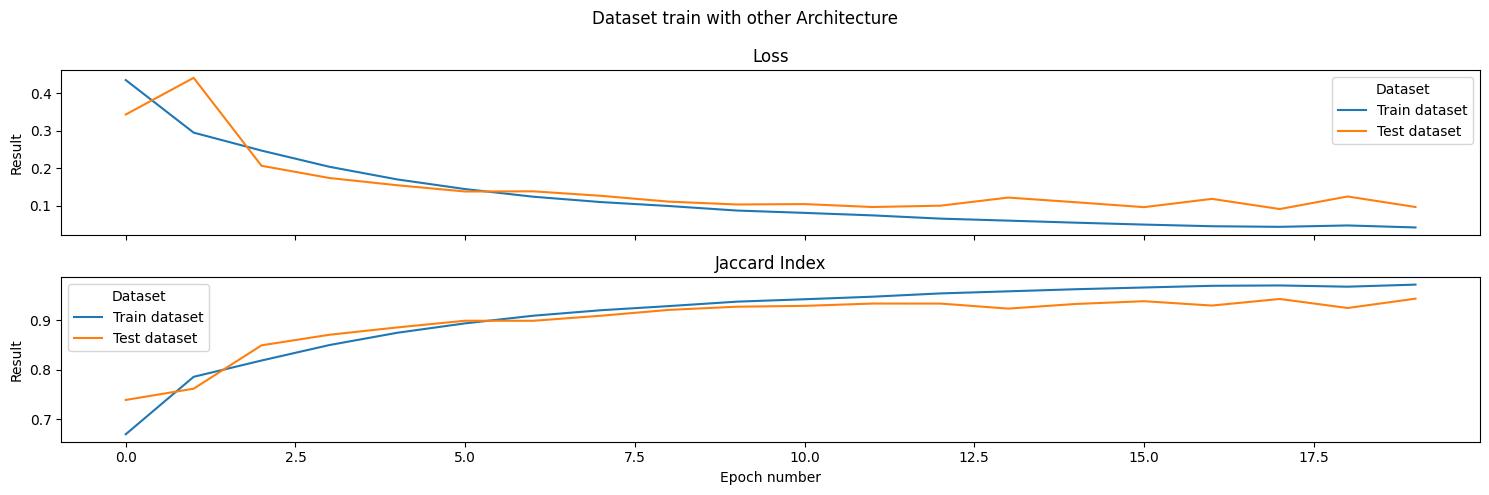

In [ ]:
results = pd.read_csv("results-architecture.csv")
show_result_plot(results, "Dataset train with other Architecture")

In [ ]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.435702
1            1             0  Train dataset  Jaccard Index  0.669511
2            2             0   Test dataset           Loss  0.343867
3            3             0   Test dataset  Jaccard Index  0.738978
4            4             1  Train dataset           Loss  0.295542
..         ...           ...            ...            ...       ...
75          75            18   Test dataset  Jaccard Index  0.925255
76          76            19  Train dataset           Loss  0.042815
77          77            19  Train dataset  Jaccard Index  0.972647
78          78            19   Test dataset           Loss  0.097312
79          79            19   Test dataset  Jaccard Index  0.944185

[80 rows x 5 columns]

Видим, что результаты получились лучше, чем при исходной архитектуре, но хуже чем TTA. Обучение проводилось с большим числом шагов. На тестовой выборке получился лучший результат Loss = 0.09, Jaccard Index = 0.94. Скорость обучения медленнее исходной модели.



# Выводы

- Переобучение на одном батче не дало идеального качества на тестовой выборке:
  + Лучшее значение Loss: 0.574;
  + Лучшее значение Jaccard Index: 0.561.
- Аугментация позволяет сильно улучшить качество предсказаний исходной модели.
  + Использование аугментации значительно увеличивает длительность обучения модели -- на тестовых данных длительность обучения возросло в три раза.
  + Лучшее значение Loss: 0.06;
  + Лучшее значение Jaccard Index: 0.966.
- Подбор гиперпараметров позволяят улучшить качество предсказаний исходной модели. На тестовых данных лучшим гиперпараметром оказался n_down = 8.
  + Подбор гиперпараметров увеличивает время обучения модели -- с n_down = 8 обучение выполняется в два раза дольше, чем с n_down = 2.
  + Лучшее значение Loss: 0.08.
  + Лучшее значение Jaccard Index: 0.953.
- Использование Test Time аугментации позволяет улучшить качество предсказаний исходной модели.
  + Использование Test Time аугментации увеличивает время обучения модели -- примерно на 5 секунд для каждого шага.
  + Лучшее значение Loss: 0.07.
  + Лучшее значение Jaccard Index: 0.957.
- Изменение архитектуры влияет на качество предсказаний.
  + В качестве примера была использована реализация из открытых источников;
  + Лучшее значение Loss: 0.07.
  + Лучшее значение Jaccard Index: 0.94.

